# citeSeq MaxFuse

This notebook trains and evaluates the MaxFuse model on citeSeq data.

<a href="https://colab.research.google.com/github/atryt0ne/cs690-multimodal-integration/blob/main/code/maxfuseciteseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install anndata scanpy maxfuse

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=7d9e1b7cffda384cc554498f6a4dce06e61b383c443a697617e3851c4b0c0ae9
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

In [ ]:
import requests, zipfile, io
r = requests.get("http://stat.wharton.upenn.edu/~zongming/maxfuse/data.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("../")

In [ ]:
# read in protein data
protein = pd.read_csv("../data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
rna = mmread("../data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('../data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
metadata = pd.read_csv('../data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2
rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

In [ ]:
correspondence = pd.read_csv('../data/protein_gene_conversion.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [ ]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)

In [ ]:
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
mask = (
    (rna_shared.X.toarray().std(axis=0) > 1e-5)
    & (protein_shared.X.std(axis=0) > 1e-5)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# row sum for RNA
rna_counts = rna_shared.X.toarray().sum(axis=1)
# row sum for protein
protein_counts = protein_shared.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

In [ ]:
# process rna_shared
sc.pp.normalize_total(rna_shared, target_sum=target_sum)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 177 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


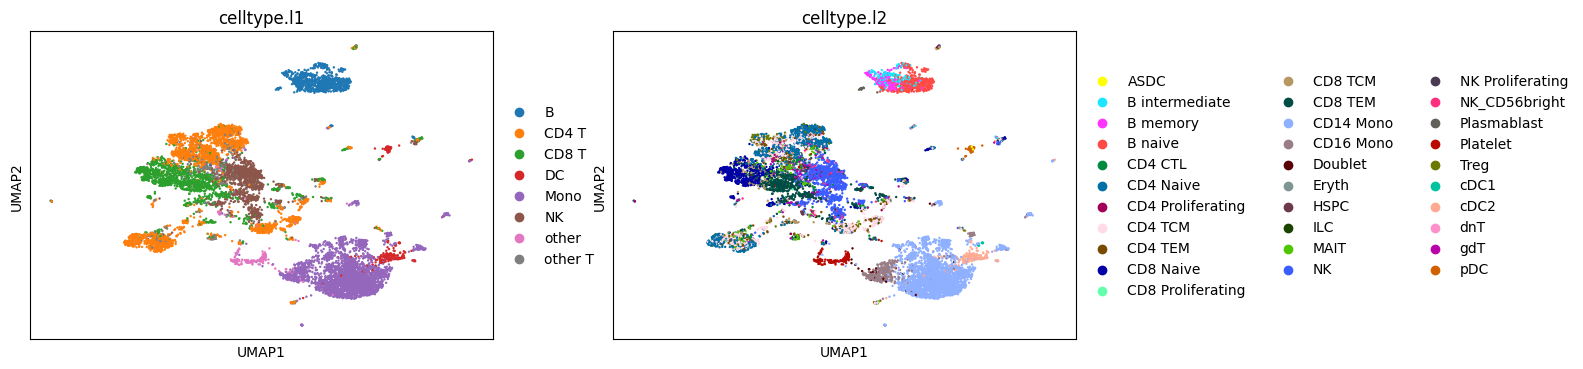

In [ ]:
sc.pp.neighbors(rna_shared, n_neighbors=15)
sc.tl.umap(rna_shared)
sc.pl.umap(rna_shared, color=['celltype.l1','celltype.l2'])

In [ ]:
rna_shared = rna_shared.X.copy()

In [ ]:
sc.pp.normalize_total(protein_shared, target_sum=target_sum)
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 177 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


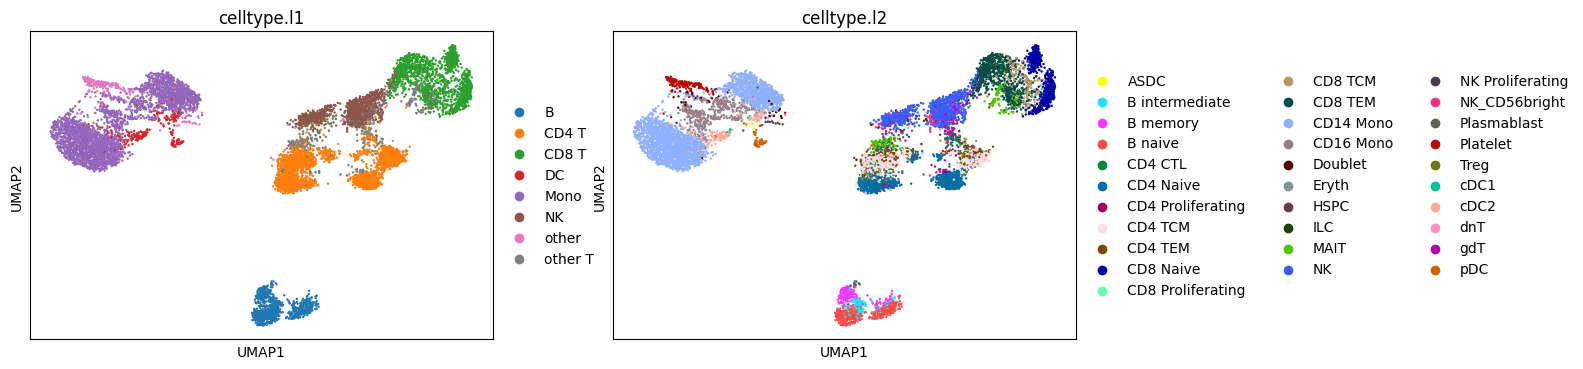

In [ ]:
# plot UMAPs of protein cells based only on protein markers with rna correspondence

sc.pp.neighbors(protein_shared, n_neighbors=15)
sc.tl.umap(protein_shared)
sc.pl.umap(protein_shared, color=['celltype.l1','celltype.l2'])

In [ ]:
protein_shared = protein_shared.X.copy()

In [ ]:
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1707 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


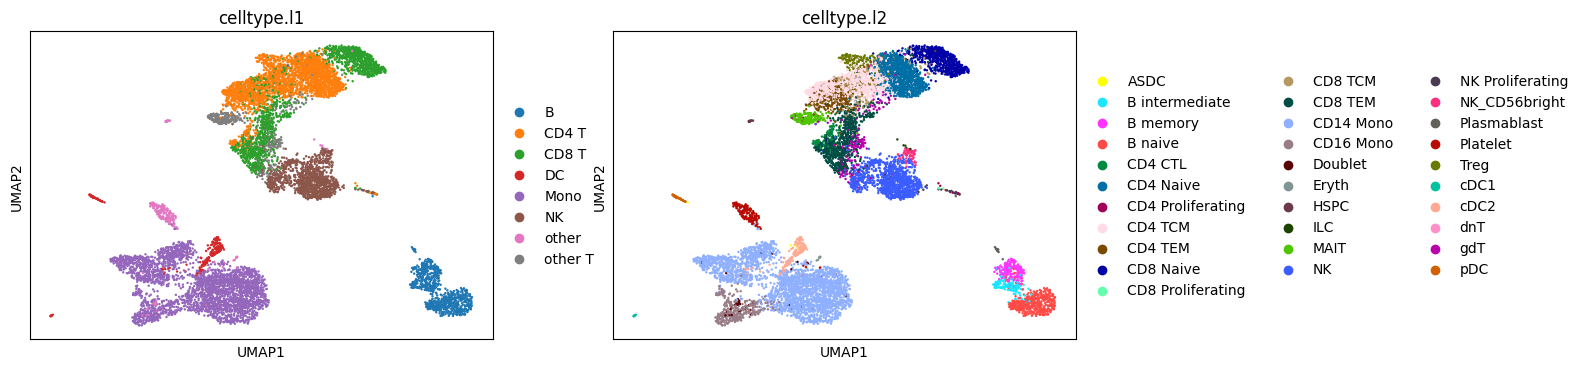

In [ ]:

sc.pp.neighbors(rna_adata, n_neighbors=15)
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata, color=['celltype.l1','celltype.l2'])

In [ ]:
sc.pp.normalize_total(protein_adata)
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 224 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


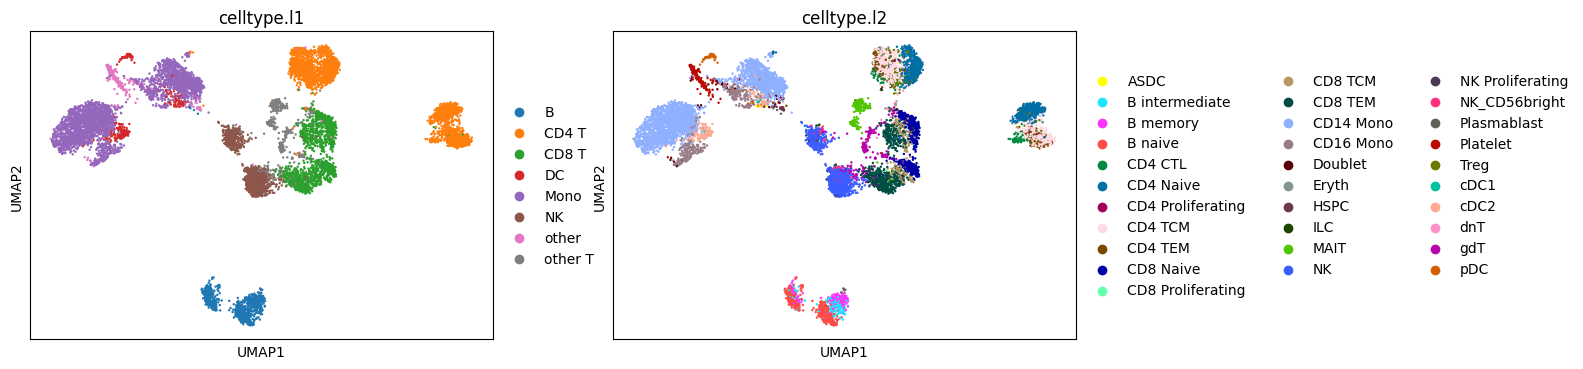

In [ ]:

sc.pp.neighbors(protein_adata, n_neighbors=15)
sc.tl.umap(protein_adata)
sc.pl.umap(protein_adata, color=['celltype.l1','celltype.l2'])

In [ ]:
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5]

In [ ]:
print(rna_active.shape)
print(protein_active.shape)
print(rna_shared.shape)
print(protein_shared.shape)

(10000, 1707)
(10000, 224)
(10000, 177)
(10000, 177)


In [ ]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [ ]:
fusor.split_into_batches(
    max_outward_size=5000,
    matching_ratio=3,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

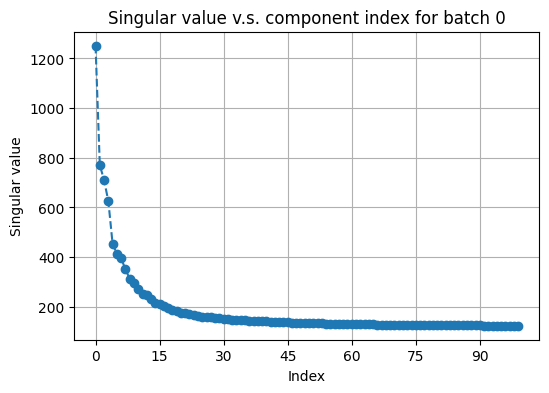

In [ ]:
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

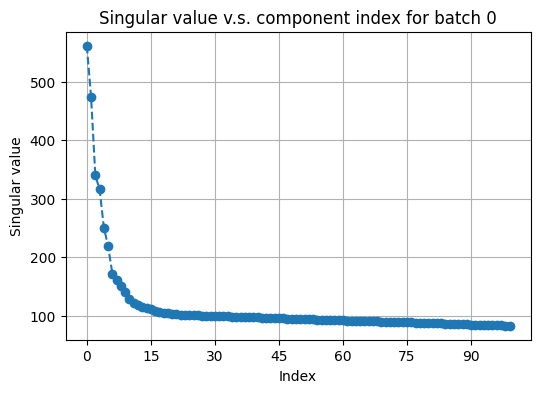

In [ ]:
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [ ]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=30,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

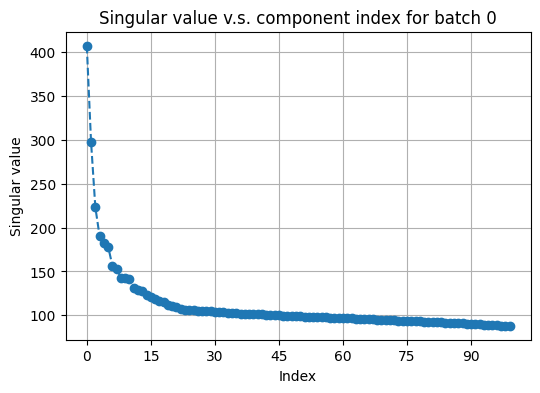

In [ ]:
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

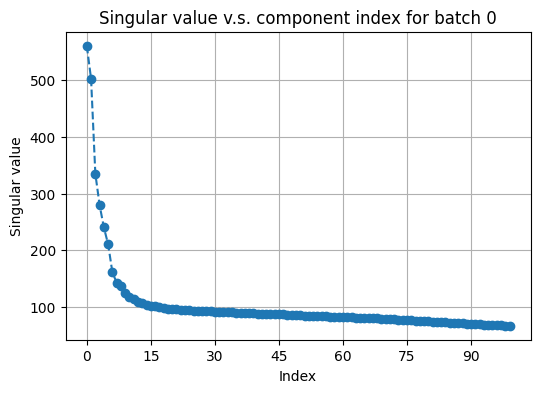

In [ ]:
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [ ]:
fusor.find_initial_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=25, svd_components2=20
)

Now at batch 0<->0...
Done!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

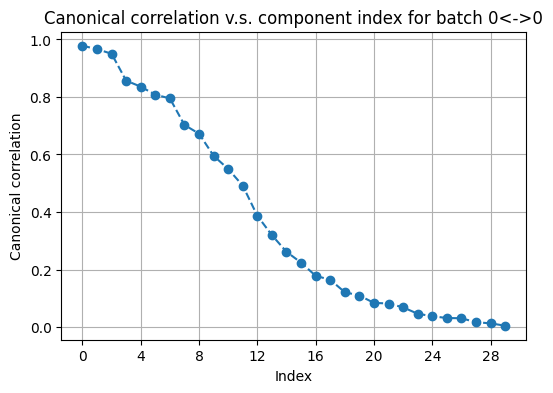

In [ ]:
fusor.plot_canonical_correlations(
    svd_components1=30,
    svd_components2=30,
    cca_components=30
)

In [ ]:
fusor.refine_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=30, svd_components2=30,
    cca_components=20,
    n_iters=3,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [ ]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
3500/5000 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
6927/10000 cells in arr1 are selected as pivots.
3500/10000 cells in arr2 are selected as pivots.
Done!


In [ ]:
pivot_matching = fusor.get_matching(target='pivot')

In [ ]:
# We can inspect the first pivot pair.
[pivot_matching[0][0], pivot_matching[1][0], pivot_matching[2][0]]

[6424, 0, 0.8931395047633097]

In [ ]:
lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching,
    labels1=labels_l1,
    labels2=labels_l1
)
lv2_acc = mf.metrics.get_matching_acc(matching=pivot_matching,
    labels1=labels_l2,
    labels2=labels_l2
)
print(f'lv1 matching acc: {lv1_acc:.3f},\nlv2 matching acc: {lv2_acc:.3f}.')

lv1 matching acc: 0.952,
lv2 matching acc: 0.869.


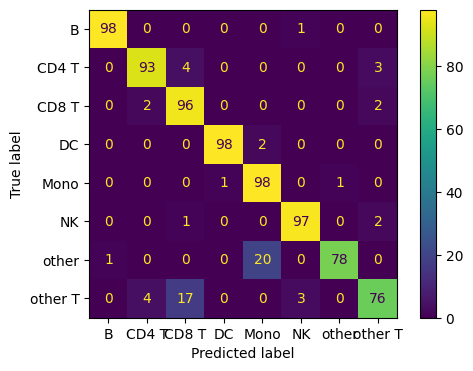

In [ ]:
cm = confusion_matrix(labels_l1[pivot_matching[0]], labels_l1[pivot_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100),
    display_labels=np.unique(labels_l1)
).plot()

In [ ]:
rna_cca, protein_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)

In [ ]:
dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

mf.metrics.get_foscttm(
    dist=mf.utils.cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.06941997

In [ ]:
cca_adata = ad.AnnData(
    np.concatenate((rna_cca[:,:dim_use], protein_cca[:,:dim_use]), axis=0),
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['rna'] * rna_cca.shape[0] + ['protein'] * protein_cca.shape[0]
cca_adata.obs['celltype.l1'] = list(labels_l1) * 2
cca_adata.obs['celltype.l2'] = list(labels_l2) * 2

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
cca_adata

AnnData object with n_obs × n_vars = 20000 × 15
    obs: 'data_type', 'celltype.l1', 'celltype.l2'

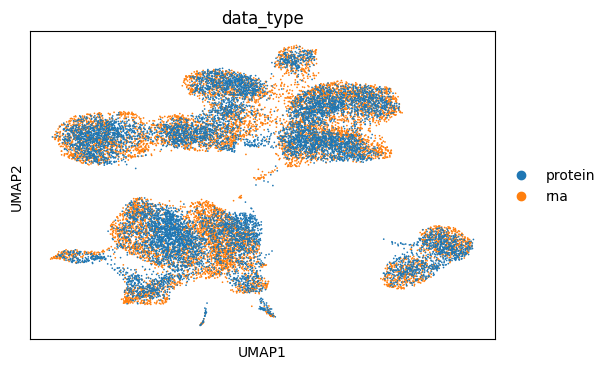

In [ ]:
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data_type')

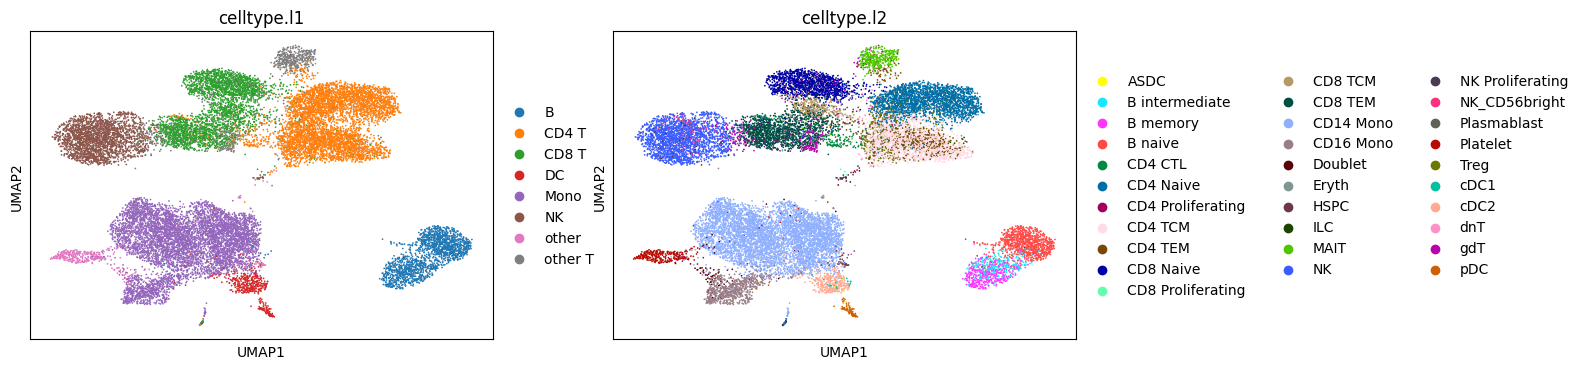

In [ ]:
sc.pl.umap(cca_adata, color=['celltype.l1', 'celltype.l2'])

In [ ]:
fusor.propagate(
    svd_components1=30,
    svd_components2=30,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Done!


In [ ]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0
)

Begin filtering...
Now at batch 0<->0...
8000/8000 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [ ]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [ ]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])),
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,6424,0,0.893140
1,5008,1,0.883026
2,7658,5,0.905430
3,6255,6,0.845224
4,2158,9,0.852431
...,...,...,...
9995,1708,9994,0.775494
9996,1849,9995,0.706753
9997,4020,9996,0.651552
9998,6892,9997,0.514235


In [ ]:
help(mf.metrics.get_matching_acc)

Help on function get_matching_acc in module maxfuse.metrics:

get_matching_acc(matching, labels1, labels2, order=None)
    Compute the cluster level matching accuracy.
    
    Parameters
    ----------
    matching: a list of length three.
        The matched pairs are (matching[0][i], matching[1][i]),
        and its score (the higher, the better) is matching[2][i].
    labels1: np.array of shape (n_samples1,)
        The first label vector.
    labels2: np.array of shape (n_samples2,)
        The first label vector.
    order: None or (1, 2) or (2, 1), default=None
        If None, then directly use matching without addressing any redundancy.
        If (1, 2), find one-to-one matching from the first dataset to the second dataset;
        if (2, 1), do the other way around.
    
    Returns
    -------
    Matching accuracy.



# LEVEL MATCHING ACCURACY

In [ ]:
# compute the cell type level matching accuracy
lv1_acc = mf.metrics.get_matching_acc(matching=full_matching,
    labels1=labels_l1,
    labels2=labels_l1
)
lv2_acc = mf.metrics.get_matching_acc(matching=full_matching,
    labels1=labels_l2,
    labels2=labels_l2
)
print(f'lv1 matching acc: {lv1_acc:.3f},\nlv2 matching acc: {lv2_acc:.3f}.')

lv1 matching acc: 0.939,
lv2 matching acc: 0.801.


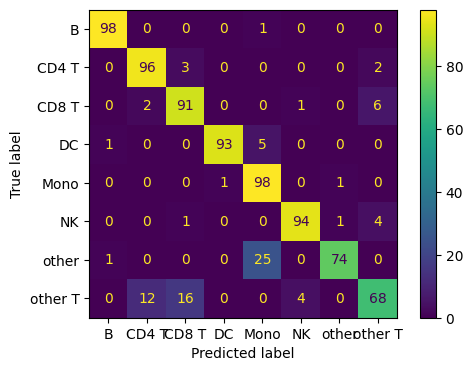

In [ ]:
# confusion matrix for full matching
cm = confusion_matrix(labels_l1[full_matching[0]], labels_l1[full_matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100),
    display_labels=np.unique(labels_l1)
).plot()

# FOSCTTM

In [ ]:
dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

mf.metrics.get_foscttm(
    dist=mf.utils.cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.06941997

#FOSCKNN

In [ ]:
help(mf.metrics.get_knn_alignment_score)


Help on function get_knn_alignment_score in module maxfuse.metrics:

get_knn_alignment_score(dist, k_max, true_matching='identity')
    For each 1 <= k <= k_max, obtain knn matching from dist,
    and compute its matching proximity with the true matching.
    The proximity is calculated by:
    for each cell in arr1, claim it is successfully matched when the true match is in the k-nearest-neighborhood;
    then calculate the average success rate.
    
    Parameters
    ----------
    dist: np.ndarray of shape (n1, n2)
        Distance matrix.
    k_max: int
        Maximum k for knn matching.
    true_matching: 'identity' or Iterable of length n1, default='identity'
        If is a list, then the ground truth matched pairs are (i, true_matching[i])
        If is 'identity', then true_matching = [0, 1..., n1].
    
    Returns
    -------
    np.ndarray of shape (k_max,) representing the score for each 1<=k<=k_max.



In [ ]:
# Determine K as 1/200th of the dataset size
dataset_size = rna_cca.shape[0]  # Assuming RNA and protein datasets have the same size
# Compute KNN alignment score
knn_alignment_score = mf.metrics.get_knn_alignment_score(
    dist=mf.utils.cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),  # Distance matrix (calculated earlier)
    true_matching='identity',  # Identity matching
    k_max=max(1, dataset_size // 200)
)

print(f"KNN Alignment Score: {knn_alignment_score}")


KNN Alignment Score: [0.0034 0.0075 0.012  0.0165 0.0204 0.0246 0.0283 0.0322 0.0361 0.039
 0.0427 0.0468 0.0494 0.052  0.0548 0.0586 0.0614 0.0635 0.0664 0.069
 0.0721 0.0747 0.0779 0.0806 0.0838 0.0876 0.0906 0.0932 0.0961 0.0988
 0.1022 0.1051 0.1082 0.1107 0.1137 0.1161 0.1172 0.1192 0.1217 0.1232
 0.1252 0.1275 0.1297 0.1319 0.1344 0.1371 0.1394 0.1426 0.1451 0.1477]


In [ ]:
import numpy as np

# Assuming `knn_scores` is the array of alignment scores for 1 <= k <= K
fosknn_score = np.mean(knn_alignment_score)
print(f"FOSKNN Score (average over all k): {fosknn_score}")


FOSKNN Score (average over all k): 0.082758


In [ ]:
true_labels = labels_l1[full_matching[0]]
predicted_labels = labels_l1[full_matching[1]]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.3f}")

F1 Score: 0.940


In [ ]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Adjusted Rand Index (ARI): 0.901


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

# Convert the categorical labels (strings) into numeric labels (integers)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(predicted_labels)

# Now, you can calculate the Silhouette Score using numeric labels
silhouette = silhouette_score(rna_cca[:, :dim_use], numeric_labels, metric='euclidean')

print(f"Silhouette Score: {silhouette:.3f}")


Silhouette Score: -0.012


In [ ]:
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(rna_cca[:, :dim_use], labels_l1)
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.168
